<h1> Example Jupyter notebook for import_potus.root </h1>
I show below how one can analyze this.<br>

<h1><font color="blue"> Necessary imports </font></h1>
Let's set up necessary imports...<br>

In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import root_numpy

<h1><font color="blue">Set up constants + data loading</font></h1>

In [2]:
FILENAME  = 'impeach_potus.root'
WF_LABELS = ['daq','wcNoiseFilter','caldata']

wf_df_array=[pd.DataFrame(root_numpy.root2array(FILENAME,x)) for x in WF_LABELS]
main_df=pd.DataFrame(root_numpy.root2array(FILENAME,'impeach'))

EVENT_KEY = ['run','subrun','event']
print
print 'impeach dataframe (',main_df.index.size,'entries) ...',len(main_df.groupby(EVENT_KEY)),'unique events'
for idx,label in enumerate(WF_LABELS):
    df = wf_df_array[idx]
    print 'Waveform dataframe with',df.index.size,'entries ...',len(df.groupby(EVENT_KEY)),'unique events by',label
print


impeach dataframe ( 1 entries) ... 1 unique events
Waveform dataframe with 3 entries ... 1 unique events by daq
Waveform dataframe with 3 entries ... 1 unique events by wcNoiseFilter
Waveform dataframe with 3 entries ... 1 unique events by caldata



<h1><font color="blue">Print waveform for 1 event</font></h1>


Accessing (run,subrun,event) = (1,0,1)


Signal @ tick [3200] position (y,z) = (0,530)
Number of electrons: [ 100000.]
Plane 0



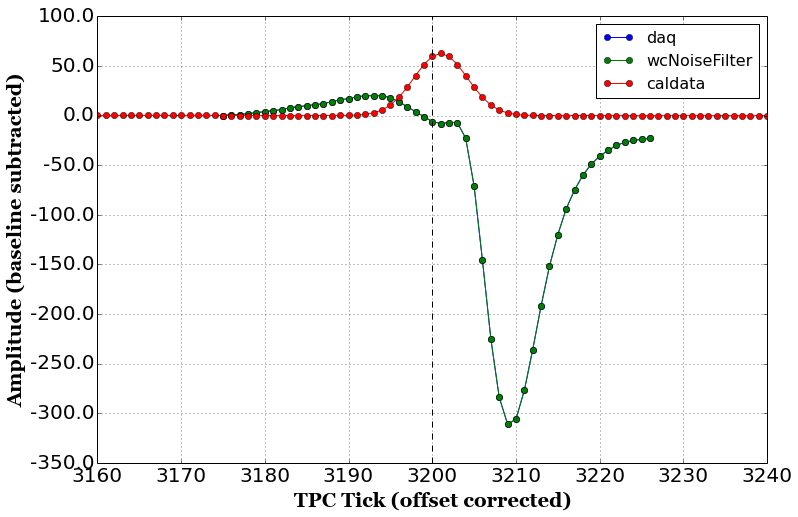

Plane 1



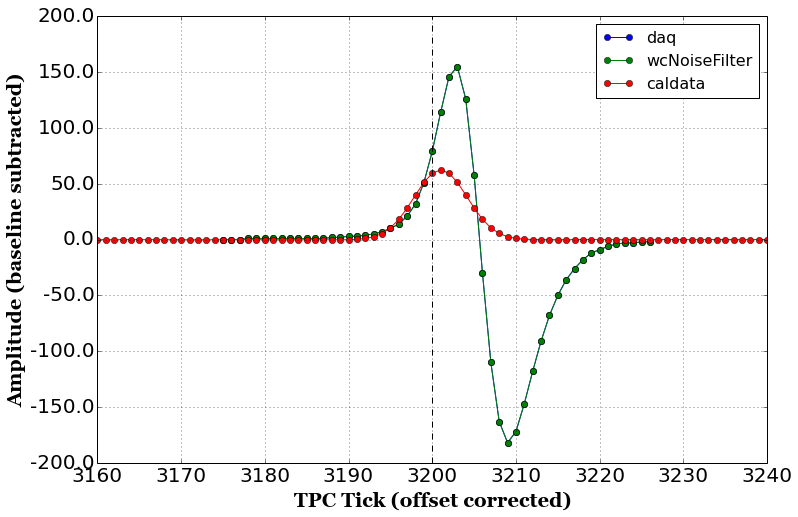

Plane 2



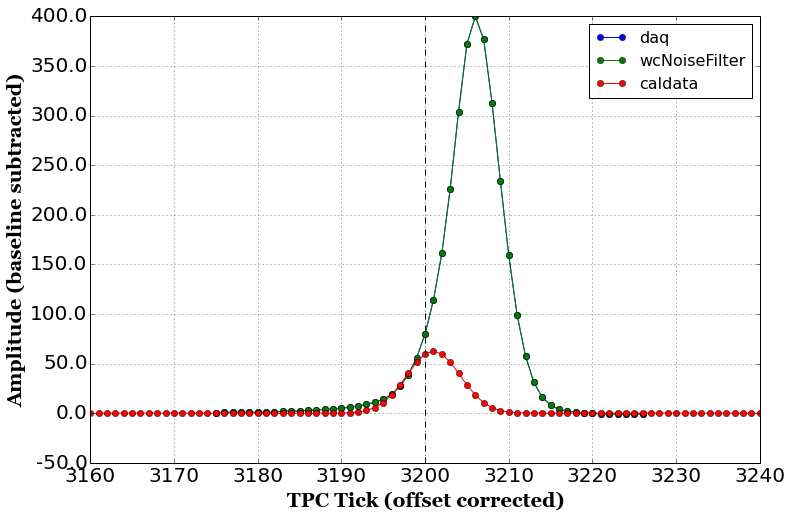

In [3]:
run,subrun,event = main_df.run.values[0], main_df.subrun.values[0], main_df.event.values[0]

print
print 'Accessing (run,subrun,event) = (%s,%s,%s)' % (run,subrun,event)
print

event_query_key = str('run==%s and subrun==%s and event==%s' % (run,subrun,event))
sub_df = main_df.query(event_query_key)

for signal_id in xrange(len(sub_df.charge_time_v.values)):

    num_electrons = sub_df.e_v.values[signal_id]
    charge_time   = sub_df.charge_time_v.values[signal_id]
    signal_tick   = sub_df.tick_v.values[signal_id]
    signal_y      = sub_df.y_v.values[signal_id]
    signal_z      = sub_df.z_v.values[signal_id]
    
    print
    print 'Signal @ tick',signal_tick,'position (y,z) = (%g,%g)' % (signal_y,signal_z)
    print 'Number of electrons:', num_electrons
    
    for plane in [0,1,2]:
        print 'Plane',plane
        print
    
        wf_query_key = event_query_key + str(' and plane==%d and signal_id==%d' % (plane,signal_id))

        fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
        for idx,label in enumerate(WF_LABELS):
            df = wf_df_array[idx].query(wf_query_key)
            wf_v = df.wf.values
            if not len(wf_v) == 1:
                print 'Something is wrong... waveform is not unique!'
                print 'producer:',label
                print 'query key:',wf_query_key
                raise ValueError
            
            start_tick = df.start_tick.values[0] + df.tick_offset.values[0]

            plt.plot(np.arange(start_tick,start_tick+len(wf_v[0]),1),
                     wf_v[0] - wf_v[0][0],
                     marker='o', label=label)

        plt.axvline(signal_tick,color='black',linestyle='--')
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        plt.tick_params(labelsize=20)
#        plt.xlim(0,31)
        plt.xlim(signal_tick-40,signal_tick+40)
        plt.grid()
        plt.xlabel('TPC Tick (offset corrected)',fontsize=20,fontweight='bold',fontname='Georgia')
        plt.ylabel('Amplitude (baseline subtracted)',fontsize=20,fontweight='bold',fontname='Georgia')
        leg=plt.legend(fontsize=16)
        leg_frame=leg.get_frame()
        leg_frame.set_facecolor('white')
            
        plt.show()
    